In [23]:
import torch
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib
from train_utils import (
    VAE_EFT,
    find_optimal_latent_dim,
    train_with_early_stopping,
    loss_function,
)

M_Z = 91.1876

### Processing training data

In [24]:
dataset = pd.read_csv("./data/SM_100k.csv")
# Apply cuts
df = dataset[
    (abs(dataset["m_ll"] - M_Z) < 15)
    & (dataset["m_jj"] > 300)
    & (abs(dataset["delta_eta_jj"]) > 2.5)
]

df.count()

m_ll            69489
m_jj            69489
pt_l1           69489
pt_l2           69489
pt_j1           69489
pt_j2           69489
pt_ll           69489
eta_l1          69489
eta_l2          69489
eta_j1          69489
eta_j2          69489
delta_eta_jj    69489
delta_phi_jj    69489
dtype: int64

In [25]:
# select variables
selection = [
    "m_ll",
    "m_jj",
    "pt_l1",
    "pt_l2",
    "pt_j1",
    "pt_j2",
    "pt_ll",
    "eta_l1",
    "eta_l2",
    "eta_j1",
    "eta_j2",
    "delta_eta_jj",
    "delta_phi_jj",
]
df = df[selection]
for vars in ["m_ll", "m_jj", "pt_l1", "pt_l2", "pt_j1", "pt_j2", "pt_ll"]:
    df[vars] = df[vars].apply(np.log10)

In [26]:
X_train, X_valid = train_test_split(df, test_size=0.1)
print(X_train.shape, X_valid.shape)

(62540, 13) (6949, 13)


In [27]:
# MinMax scaling
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_valid = t.transform(X_valid)

In [28]:
# create train and test dataloaders
batch_size = 50
train_loader = DataLoader(dataset=X_train, batch_size=batch_size)
valid_loader = DataLoader(dataset=X_valid, batch_size=batch_size)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Explore latent dims for reconstruction

In [16]:
find_optimal_latent_dim(VAE_EFT, train_loader, valid_loader, loss_function, device, 12)


Testing latent dimension: 1
Epoch 0 | Train: 8.33e+00, 2.61e-05 | Val: 8.29e+00, 3.04e-05


KeyboardInterrupt: 

In [8]:
results = {
    1: {
        "best_epoch": 2,
        "best_loss": 8.274900317681167,
        "loss_history": [
            8.281615644390374,
            8.281137842806332,
            8.274900317681167,
            8.277660264137578,
            8.393617115172336,
            8.372322094999106,
            8.372680218448739,
            8.373762786049856,
        ],
    },
    2: {
        "best_epoch": 9,
        "best_loss": 8.05647491136727,
        "loss_history": [
            8.180476988881587,
            8.15738801847673,
            8.136093951036594,
            8.144007275458208,
            8.136808304253922,
            8.099294085901189,
            8.111373974756066,
            8.070459814152374,
            8.061918996090014,
            8.05647491136727,
            8.202202907552905,
            8.061923442893738,
            8.073080469106465,
            8.099406010911414,
            8.122959841988019,
        ],
    },
    3: {
        "best_epoch": 3,
        "best_loss": 7.973816949676949,
        "loss_history": [
            8.160523510749135,
            8.024734821865307,
            8.013548264830828,
            7.973816949676949,
            7.981278282702471,
            7.978480630010102,
            8.005778694170445,
            8.024055419871805,
            8.022352235953985,
        ],
    },
    4: {
        "best_epoch": 20,
        "best_loss": 7.851165890234771,
        "loss_history": [
            8.081909476689288,
            8.012882295730469,
            7.962203385429005,
            7.925481023971786,
            7.902173992918111,
            7.901349227585388,
            7.891278794111331,
            7.885061888893749,
            7.890427876613329,
            7.878784810244666,
            7.883772376546659,
            7.887808169636023,
            7.872637040791228,
            7.873309231932716,
            7.878557177815647,
            7.8709515038908755,
            7.871870124873355,
            7.864258577576771,
            7.874431568862792,
            7.871377703324177,
            7.851165890234771,
            7.864667174020566,
            7.889170573065648,
            7.880848733836639,
            7.88439667893153,
            7.869110733075224,
        ],
    },
    5: {
        "best_epoch": 17,
        "best_loss": 7.81626998836492,
        "loss_history": [
            8.074655249784762,
            7.951810774455198,
            7.9251251584378295,
            7.869397753833325,
            7.84845445336157,
            7.8416235484779735,
            7.84408945521938,
            7.82620032407244,
            7.826876712504394,
            7.823513126865525,
            7.8361430828697145,
            7.826641842870116,
            7.824253251904208,
            7.826826249830904,
            7.819740119339881,
            7.830151276983327,
            7.82551414878841,
            7.81626998836492,
            7.848417283405114,
            7.817873481086644,
            7.821979468629667,
            7.819955606491603,
            7.822151313316918,
        ],
    },
    6: {
        "best_epoch": 10,
        "best_loss": 7.7713280554744335,
        "loss_history": [
            8.036995094648194,
            7.926577850374389,
            7.90348548491196,
            7.86085961404053,
            7.864773537123424,
            7.815647723020501,
            7.791360008509897,
            7.781706703191284,
            7.772365374909205,
            7.77222538325283,
            7.7713280554744335,
            7.804445374425396,
            7.775884031957817,
            7.778725352331893,
            7.78989682733291,
            7.801492287052571,
        ],
    },
    7: {
        "best_epoch": 26,
        "best_loss": 7.716895372240363,
        "loss_history": [
            8.030248612816766,
            7.946315634044658,
            7.928886388467141,
            7.914006195538918,
            7.897036545108302,
            7.848831411030555,
            7.834904238530628,
            7.8494653087338335,
            7.825344807030972,
            7.789153457455323,
            7.793661198909627,
            7.769212613009092,
            7.805515638506469,
            7.7370774243359515,
            7.73014917256156,
            7.732014223492621,
            7.729731122546354,
            7.728843307378839,
            7.729814177138843,
            7.725808799395527,
            7.729157874630418,
            7.7289152347489205,
            7.721048163535808,
            7.720216350601127,
            7.726468276671388,
            7.722609508038197,
            7.716895372240363,
            7.722748502571071,
            7.741881496819709,
            7.7508748288719085,
            7.7211705394208705,
            7.723250660812533,
        ],
    },
    8: {
        "best_epoch": 36,
        "best_loss": 7.686907568348355,
        "loss_history": [
            8.171467692069935,
            8.053055350288641,
            7.93906637955817,
            7.88020793880054,
            7.851451979471258,
            7.854298319310022,
            7.808167703919291,
            7.807973710864658,
            7.793101709746788,
            7.7896475943405425,
            7.774281683583194,
            7.748655481014194,
            7.740537283580812,
            7.736004395133193,
            7.73147376705093,
            7.729421736905301,
            7.726453839280256,
            7.7229595768912525,
            7.722848439507976,
            7.722920220098875,
            7.726100929692583,
            7.730635760395053,
            7.726535954951931,
            7.716401843646526,
            7.719529332481644,
            7.710053938864406,
            7.702128297393022,
            7.705428093652734,
            7.699735044249072,
            7.696552629754685,
            7.694601942525633,
            7.704542912158996,
            7.695652419622112,
            7.692107515442223,
            7.693860300374824,
            7.692837373455096,
            7.686907568348355,
            7.69492926870128,
            7.691454550216536,
            7.691218885081083,
            7.686931076752979,
            7.690757320833042,
        ],
    },
    9: {
        "best_epoch": 41,
        "best_loss": 7.664982983020498,
        "loss_history": [
            8.052750389206746,
            7.923006044879025,
            7.861278785181389,
            7.84994419462531,
            7.810123284480758,
            7.7918286061484565,
            7.786868094374704,
            7.752147074837409,
            7.745015094237774,
            7.723731349948999,
            7.731118072299757,
            7.704019798242004,
            7.7077608285791275,
            7.704376630489631,
            7.69910317244838,
            7.699064052713583,
            7.700755117195872,
            7.703391138658997,
            7.699777112826691,
            7.697114275070845,
            7.70667510940438,
            7.693120816881128,
            7.690192141944091,
            7.693701758943041,
            7.689409017558042,
            7.692401542773789,
            7.706887114634882,
            7.675726349218797,
            7.676552725047624,
            7.670200725577025,
            7.669788680827114,
            7.675024236429083,
            7.674742138014919,
            7.671793482176823,
            7.668130179582065,
            7.670631976388436,
            7.673033364997657,
            7.670349140002302,
            7.671499029118278,
            7.668016435201829,
            7.668501097800461,
            7.664982983020498,
            7.66829433932413,
            7.666834755337499,
            7.668960288917627,
            7.671837671886653,
            7.666681006571445,
        ],
    },
    10: {
        "best_epoch": 31,
        "best_loss": 7.661047212674515,
        "loss_history": [
            8.074059184135868,
            7.954185180646548,
            7.933803777170995,
            7.9054445774792965,
            7.851986569293277,
            7.809325622672074,
            7.797528670986699,
            7.7864095388633,
            7.7805855228836664,
            7.742510596594797,
            7.722875642747634,
            7.712637598311882,
            7.71306221403082,
            7.7126732906108195,
            7.708870299501853,
            7.714332067784924,
            7.715111557826355,
            7.710145229838469,
            7.698056455424816,
            7.681726274464381,
            7.671821617494943,
            7.674868001396413,
            7.672194622950616,
            7.673394037214676,
            7.673780551692159,
            7.670458016173401,
            7.682798480762612,
            7.676421974752037,
            7.66352378008085,
            7.663535424964819,
            7.667968942226642,
            7.661047212674515,
            7.662139591226971,
            7.661762909079547,
            7.674866559700775,
            7.6615128186429,
            7.661645839742272,
        ],
    },
    11: {
        "best_epoch": 20,
        "best_loss": 7.670245868523052,
        "loss_history": [
            7.971000798790079,
            7.929600572332442,
            7.910281852265077,
            7.859368521246736,
            7.79742796245891,
            7.779031941117305,
            7.748442075102534,
            7.748919482953338,
            7.731849745640488,
            7.732029220459135,
            7.707062983945818,
            7.7000724025147935,
            7.70205558583573,
            7.695549731375482,
            7.6847100374457895,
            7.681006328429484,
            7.678185423882769,
            7.673198361161494,
            7.67647146185826,
            7.67362545751408,
            7.670245868523052,
            7.673856704366281,
            7.671003256864023,
            7.677627236707717,
            7.677400018167543,
            7.671860130931875,
        ],
    },
    12: {
        "best_epoch": 26,
        "best_loss": 7.659514409021605,
        "loss_history": [
            7.96229107339203,
            7.931454859344214,
            7.909137721607899,
            7.857389827518989,
            7.8461415294739005,
            7.84363239790227,
            7.8399492905223305,
            7.834603555985971,
            7.796544114612079,
            7.750505962436821,
            7.741681252839412,
            7.7394193706521595,
            7.743843840566774,
            7.730670749121634,
            7.729535528706329,
            7.710097462798596,
            7.695237473843911,
            7.679503544219349,
            7.680504574944646,
            7.6766056216816665,
            7.681377911686747,
            7.662452629432888,
            7.662409663112376,
            7.662284896476446,
            7.663088648403524,
            7.681216717421359,
            7.659514409021605,
            7.667356915369759,
            7.664118782323357,
            7.660436530329279,
            7.65984210186494,
            7.660091724574292,
        ],
    },
}

In [14]:
df = pd.DataFrame(results).transpose()
df.head()

,best_epoch,best_loss,loss_history
1,2,8.2749,"[8.281615644390374, 8.281137842806332, 8.27490..."
2,9,8.056475,"[8.180476988881587, 8.15738801847673, 8.136093..."
3,3,7.973817,"[8.160523510749135, 8.024734821865307, 8.01354..."
4,20,7.851166,"[8.081909476689288, 8.012882295730469, 7.96220..."
5,17,7.81627,"[8.074655249784762, 7.951810774455198, 7.92512..."


Text(0, 0.5, 'Best epoch')

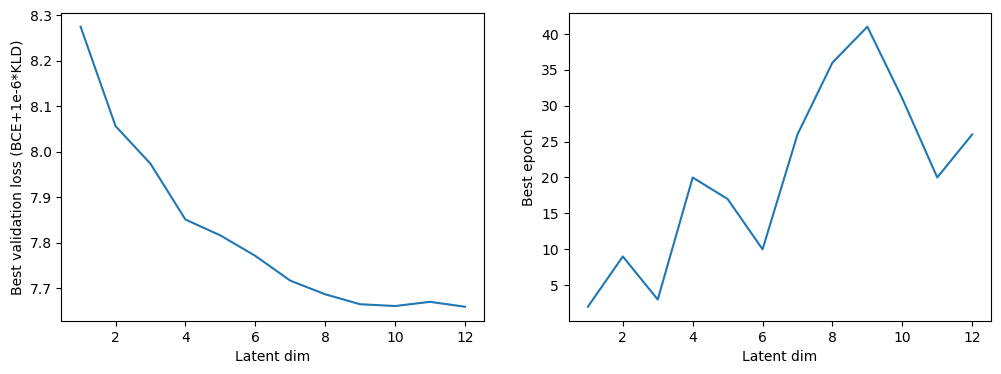

In [23]:
X = np.linspace(1, 12, 12)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(X, df["best_loss"])
ax[0].set_xlabel("Latent dim")
ax[0].set_ylabel("Best validation loss (BCE+1e-6*KLD)")
ax[1].plot(X, df["best_epoch"])
ax[1].set_xlabel("Latent dim")
ax[1].set_ylabel("Best epoch")

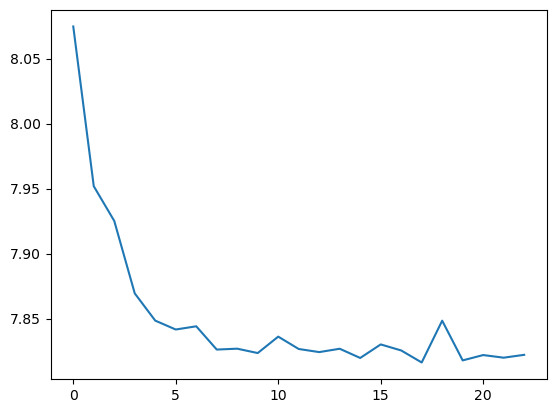

In [28]:
plt.plot(df["loss_history"][5])

### Training and saving the model

In [31]:
l = 6
path = f"./models/VAE_l_{l}.pth"
model = VAE_EFT(latent_dim=l).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
train_with_early_stopping(
    model, train_loader, valid_loader, loss_function, optimizer, device, save_path=path
)

Epoch 0 | Train: 8.18e+00, 6.46e-05 | Val: 8.04e+00, 6.23e-05
Epoch 1 | Train: 7.95e+00, 7.15e-05 | Val: 7.90e+00, 6.65e-05
Epoch 2 | Train: 7.90e+00, 6.15e-05 | Val: 7.89e+00, 6.94e-05
Epoch 3 | Train: 7.86e+00, 6.65e-05 | Val: 7.85e+00, 6.32e-05
Epoch 4 | Train: 7.84e+00, 6.05e-05 | Val: 7.83e+00, 6.17e-05
Epoch 5 | Train: 7.83e+00, 5.87e-05 | Val: 7.82e+00, 5.96e-05
Epoch 6 | Train: 7.83e+00, 5.67e-05 | Val: 7.82e+00, 5.72e-05
Epoch 7 | Train: 7.81e+00, 5.58e-05 | Val: 7.78e+00, 5.44e-05
Epoch 8 | Train: 7.78e+00, 5.24e-05 | Val: 7.77e+00, 5.27e-05
Epoch 9 | Train: 7.77e+00, 5.21e-05 | Val: 7.76e+00, 5.32e-05
Epoch 10 | Train: 7.76e+00, 5.08e-05 | Val: 7.75e+00, 5.42e-05
Epoch 11 | Train: 7.77e+00, 5.08e-05 | Val: 7.75e+00, 5.27e-05
Epoch 12 | Train: 7.77e+00, 5.04e-05 | Val: 7.77e+00, 5.00e-05
Epoch 13 | Train: 7.77e+00, 4.92e-05 | Val: 7.76e+00, 4.74e-05
Epoch 14 | Train: 7.77e+00, 4.87e-05 | Val: 7.76e+00, 5.22e-05
Epoch 15 | Train: 7.76e+00, 4.79e-05 | Val: 7.76e+00, 4.65e-05

E

(10,
 7.749692081074213,
 [8.039916405310908,
  7.903415321154629,
  7.888995327061519,
  7.848096555857526,
  7.830918769954669,
  7.824233201130184,
  7.821436186180155,
  7.783084738499601,
  7.765268275670482,
  7.7582150039778455,
  7.749692081074213,
  7.7537078928236705,
  7.767050718452665,
  7.7645396297597,
  7.755661284130361,
  7.761603610508883])

In [32]:
scaler_filename = f"./models/VAE_l_{l}_scaler.save"
joblib.dump(t, scaler_filename)

['./models/VAE_l_6_scaler.save']